In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
#from analysis import tnp, tnp_mode
#tnp_mode(1);
import pandas as pd
import nflows as nf

# NF example

In [3]:
from analysis.mc import ImportanceSamplingIntegrator

In [4]:
class NFlowImportanceSamplingIntegrator(ImportanceSamplingIntegrator):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        
    def sample(self, n_samples:int=1, with_importance:bool=False):
        pass
    
    def adapt(self, n_samples:int=1000000):
        self.adapted = True
        pass

In [6]:
# Physics
#from analysis.cffi.mg5.lib import mc_batch, mc_batch_sigma
from analysis.import_data import import_true_reco
import numpy as np
import pandas as pd

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from nflows import transforms, distributions, flows
from normflows.nets.resnet import ResidualNet

In [8]:
import torch

# From https://github.com/VincentStimper/normalizing-flows
def create_alternating_binary_mask(features, even=True):
    """Creates a binary mask of a given dimension which alternates its masking.

    Args:
      features: Dimension of mask.
      even: If True, even values are assigned 1s, odd 0s. If False, vice versa.

    Returns:
      Alternating binary mask of type torch.Tensor.
    """
    mask = torch.zeros(features).byte()
    start = 0 if even else 1
    mask[start::2] += 1
    return mask

def transform_net_create_fn(in_features, out_features):
    if len(ind_circ_id) > 0:
        pf = PeriodicFeaturesElementwise(in_features, ind_circ_id, scale_pf)
    else:
        pf = None
    net = ResidualNet(
        in_features=in_features,
        out_features=out_features,
        context_features=num_context_channels,
        hidden_features=num_hidden_channels,
        num_blocks=num_blocks,
        activation=activation(),
        dropout_probability=dropout_probability,
        use_batch_norm=False,
        preprocessing=pf,
    )
    if init_identity:
        torch.nn.init.constant_(net.final_layer.weight, 0.0)
        torch.nn.init.constant_(
            net.final_layer.bias, np.log(np.exp(1 - DEFAULT_MIN_DERIVATIVE) - 1)
        )
    return net

In [7]:
in_features = 2

transform = transforms.CompositeTransform([
    transforms.PiecewiseRationalQuadraticCouplingTransform(mask=create_alternating_binary_mask(in_features),
                                                           )
])

TypeError: PiecewiseRationalQuadraticCouplingTransform.__init__() missing 2 required positional arguments: 'mask' and 'transform_net_create_fn'

In [ ]:
transforms.PiecewiseRationalQuadraticCouplingTransform

In [16]:
import normflows as nf
import torch
from typing import Optional, Callable

def print_model_summary(model):
    print(
        'Model: %s\nParameters: %i' %
        (model, sum(p.numel() for p in model.parameters()))
    )

def get_nfm(q0:Optional[BaseDistribution]=None,
            K:int = 16,
            latent_size:int = 2,
            hidden_units: int = 256,
            hidden_layers:int = 2,
            cuda_if_available:bool = True,
            flow:Callable = nf.flows.CoupledRationalQuadraticSpline,#nf.flows.AutoregressiveRationalQuadraticSpline,
            linear_permute:bool = True,
            flow_args:dict = {'num_bins': 30, 'tails': 'linear', 'tail_bound': -2 },
            seed:Optional[int]=None):
    
    if seed is not None:
        torch.manual_seed(seed)

    flows = []
    for i in range(K):
        flows += [flow(latent_size, hidden_layers, hidden_units, **flow_args)]
        if linear_permute:
            flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribuiton
    if q0 is None:
        #q0 = nf.distributions.DiagGaussian(latent_size, trainable=False)
        q0 = nf.distributions.Uniform(latent_size)
        
    # Construct flow model
    nfm = nf.NormalizingFlow(q0=q0, flows=flows)

    print("Using device " + f"GPU ({torch.cuda.get_device_name(0)})" if torch.cuda.is_available() else "CPU")
    print(f"Model with {sum(p.numel() for p in nfm.parameters())} parameters")
    
    # Move model on GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() and cuda_if_available else 'cpu')
    return nfm.to(device)

(array([[18., 23., 26., ..., 23., 19., 24.],
        [22., 25., 19., ..., 21., 28., 22.],
        [27., 15., 29., ..., 16., 25., 24.],
        ...,
        [29., 21., 24., ..., 25., 24., 29.],
        [22., 17., 25., ..., 30., 23., 17.],
        [30., 25., 26., ..., 23., 33., 26.]]),
 array([-1.99992681e+00, -1.93742853e+00, -1.87493026e+00, -1.81243198e+00,
        -1.74993370e+00, -1.68743543e+00, -1.62493715e+00, -1.56243888e+00,
        -1.49994060e+00, -1.43744233e+00, -1.37494405e+00, -1.31244578e+00,
        -1.24994750e+00, -1.18744923e+00, -1.12495095e+00, -1.06245268e+00,
        -9.99954402e-01, -9.37456127e-01, -8.74957852e-01, -8.12459577e-01,
        -7.49961302e-01, -6.87463026e-01, -6.24964751e-01, -5.62466476e-01,
        -4.99968201e-01, -4.37469926e-01, -3.74971651e-01, -3.12473375e-01,
        -2.49975100e-01, -1.87476825e-01, -1.24978550e-01, -6.24802746e-02,
         1.80006027e-05,  6.25162758e-02,  1.25014551e-01,  1.87512826e-01,
         2.50011101e-01,  3.125

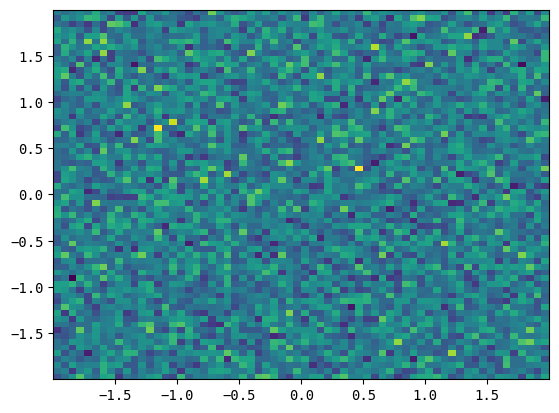

In [17]:
#a = HyperUniform(low=[-2,-2], high=[2, 2], trainable=False)
a = nf.distributions.base.Uniform(2, low=-2., high=2.)
#a = nf.distributions.base.DiagGaussian(2, trainable=False)

z = a.sample(100000)

pX = z.T[0].detach().cpu().numpy()
pY = z.T[1].detach().cpu().numpy()

plt.hist2d(pX, pY, bins=(64,64))

In [18]:
def plot_proposal(nfm, n_samples:int=1024):
    cs = nfm.sample(n_samples)
    samples = cs[0].detach().cpu().numpy()

    all_max = np.max(samples).max()
    all_min = np.min(samples).min()
    print(f'Using inferred bounds {all_min:.3f} to {all_max:.3f}')
    #print((all_min, all_max))

    plot_hist(pd.DataFrame(dict(x=samples.T[0], y=samples.T[1])), normalize=True, xlim=(all_min, all_max), xlim_binning=(all_min, all_max))
    if False:
        fig, ax = plt.subplots()
        ax.set_title("q0")
        for i in range(len(samples.T)):
            ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}",
                    bins=64, range=(all_min, all_max))
            ax.set_xlim(all_min, all_max)
        ax.legend()
        
def plot_integrand(nfm, func, n_samples:int=2048, vwindow=None,
                   is_nfm:bool=True, y_log:bool=False):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
    else:
        samples = nfm.sample(n_samples)
    
    #samples = samples.detach().cpu().numpy()
    results = func(samples).detach().cpu().numpy()
    
    for i in range(len(samples.T)):
        fig, ax = plt.subplots()
        #ax.hist(samples.T[i], alpha=0.4, label=f"Dim {i}", bins=64)
        ax.scatter(x=samples.T[i].detach().cpu().numpy(),
                y=results)
        
        if vwindow is not None:
            if len(vwindow) > 2 and len(vwindow) == len(samples.T):
                ax.set_ylim(vwindow[i])
            else:
                ax.set_ylim(vwindow)
            
        ax.set_title('Integrand projection')
        ax.set_xlabel(f"Dim {i}")
        ax.set_ylabel('Integrand value')
        plt.show()
    
    fig, ax = plt.subplots()
    ax.hist(results, bins=32)
    ax.set_xlabel('Integrand value')
    if y_log:
        ax.set_yscale('log')
    ax.set_title('All results')
    
def get_result(nfm, func:Callable, n_samples:int=1024, is_nfm:bool=True):
    if is_nfm:
        samples, log_p = nfm.sample(n_samples)
        prob = log_p.exp().detach()#.cpu().numpy()
    else:
        samples = nfm.sample(n_samples)
        prob = torch.ones(n_samples) * nfm.log_prob_val.exp()
    
    res = func(samples)/prob
    
    integral = (1/n_samples * res.sum()).detach().cpu().numpy().item()
    delta = (torch.var(res).detach().cpu()/n_samples).sqrt().numpy().item()
    
    return integral, delta

CPU
Model with 1246080 parameters


Using inferred bounds -2.000 to 2.000


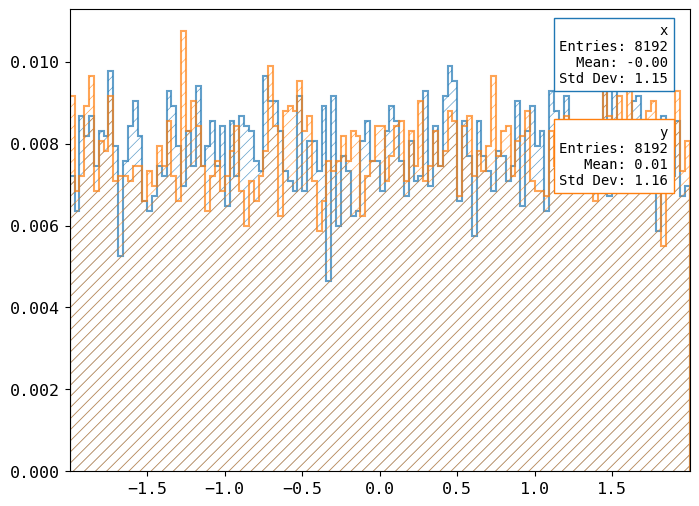

In [19]:
nfm = get_nfm(q0=a, hidden_units=128)
plot_proposal(nfm, n_samples=8192)

In [20]:
def func(args):
    return torch.exp(-1*torch.sqrt(args.T[0]**2 + args.T[1]**2))
    #return args.T[0]**3 + torch.exp(-10* args.T[1]**2)

In [21]:
get_result(a, func, is_nfm=False, n_samples=10000)

(4.118322849273682, 0.026066992431879044)

In [22]:
get_result(nfm, func)

(4.098833084106445, 0.08054687082767487)

In [23]:
samples, log_p = nfm.sample(1000)
results = func(samples).detach().cpu().numpy()

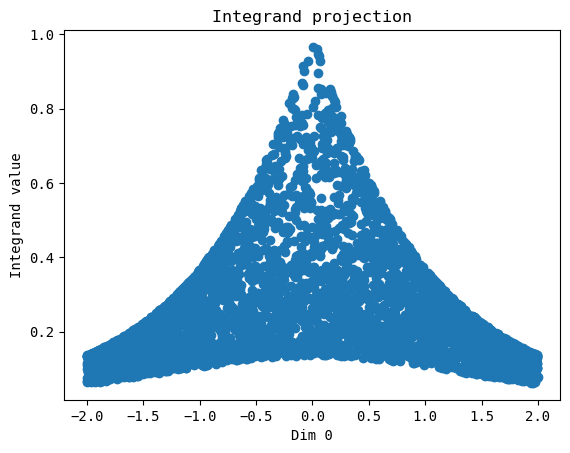

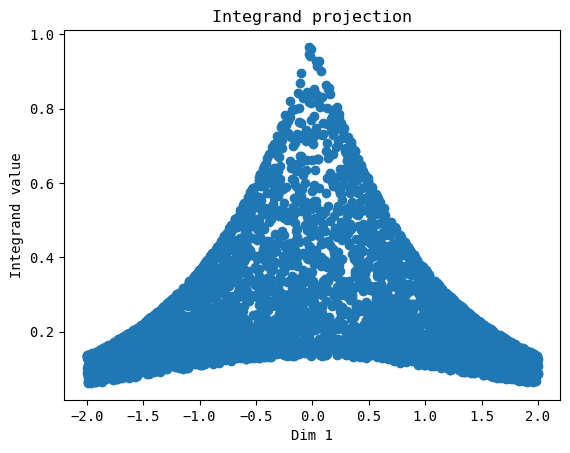

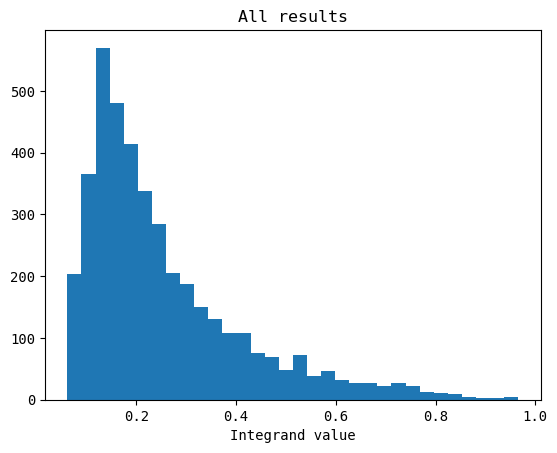

In [24]:
plot_integrand(nfm, func, n_samples=4096)

In [25]:
def train_iflow(nfm, func, n_samples:int=10000, n_epochs:int=20, lr:float=1e-4):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=lr)
    for i in range(n_epochs):
        optimizer.zero_grad()
        
        z, logq = nfm.q0(n_samples)
        true = torch.abs(func(z)).detach()
        logp = torch.where(true > 1e-16, true.log(), true + 1e-16).detach()
        
        # Transform through NFlow
        for flow in nfm.flows:
            z, log_det = flow(z)
            logq -= log_det
        
        test = logq.exp().detach()
        
        mean = torch.mean(true/test)
        var = torch.var(true/test)
        
        true = true/mean
        loss = (1/n_samples) * ((true/test) * (logp - logq)**2).sum()
        
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()} | Var {var}")
        
def train_backward(nfm, func, n_samples:int=32000, n_epochs:int=10):
    optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3)
    p = nfm.q0.log_prob_val.exp()
    
    for i in range(n_epochs):
        optimizer.zero_grad()
        samples, log_p = nfm.sample(n_samples)
        
        prob = log_p.exp()
        results = func(samples).detach()
        
        loss = (1/n_samples * (1/(p*prob)) * results**2).sum()
        loss.backward()
        optimizer.step()
        
        #if i % 10 == 0:
        print(f"Epoch {i}: {loss.item()}")

In [26]:
#train_forward(nfm, func, n_epochs=10)
train_iflow(nfm, func, n_epochs=10)

Epoch 0: 2.84445858001709 | Var 6.667990207672119
Epoch 1: 2.823622941970825 | Var 6.53604793548584
Epoch 2: 2.8222622871398926 | Var 6.466372966766357
Epoch 3: 2.877758026123047 | Var 6.822723388671875
Epoch 4: 2.8329455852508545 | Var 6.662502765655518
Epoch 5: 2.820488691329956 | Var 6.542181015014648
Epoch 6: 2.8223214149475098 | Var 6.568058490753174
Epoch 7: 2.812894344329834 | Var 6.473564147949219
Epoch 8: 2.7949981689453125 | Var 6.520290374755859
Epoch 9: 2.747685194015503 | Var 6.206135272979736


Using inferred bounds -1.980 to 1.980


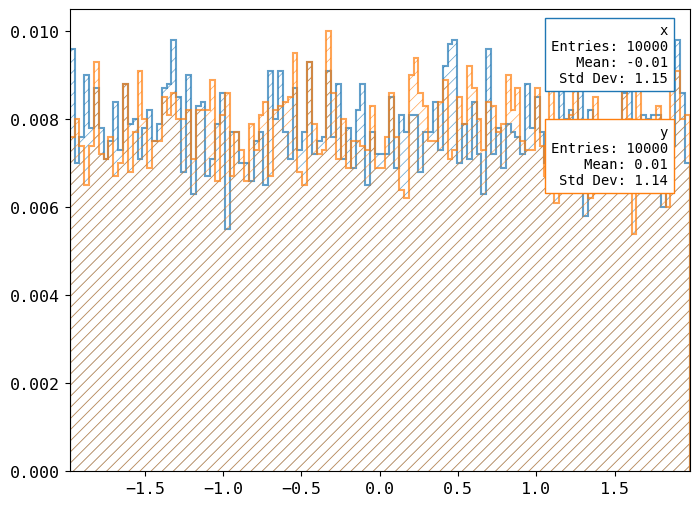

In [27]:
plot_proposal(nfm, n_samples=10000)

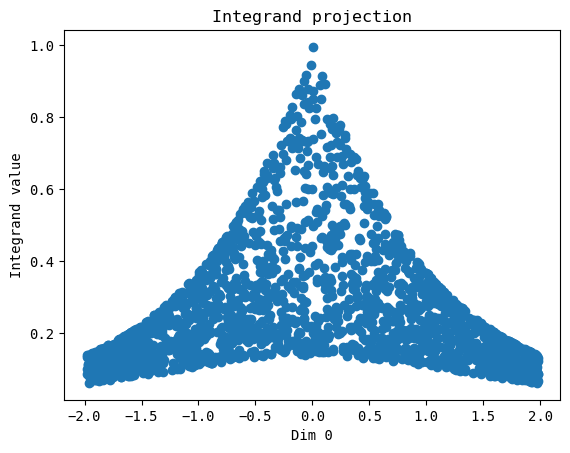

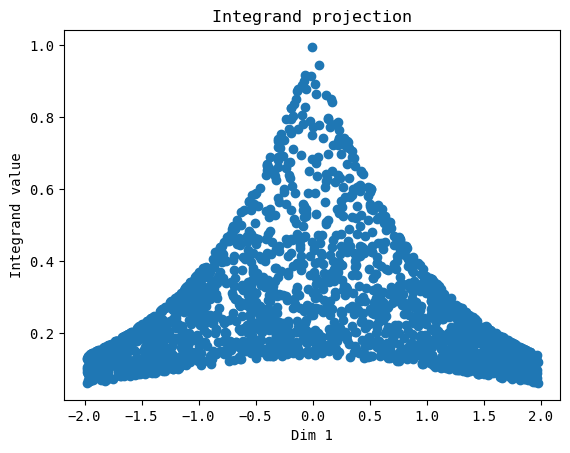

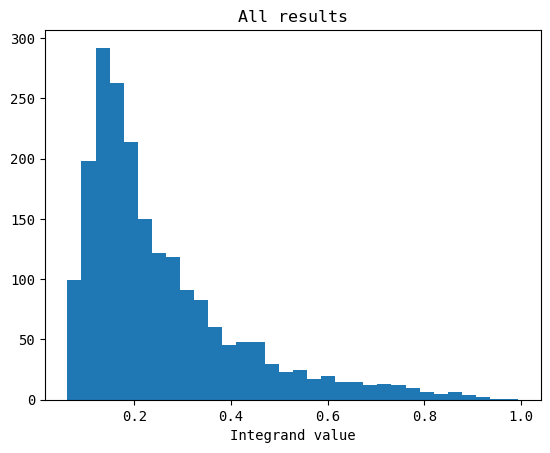

In [28]:
plot_integrand(nfm, func, y_log=False)

In [29]:
get_result(nfm, func, n_samples=4096)

(4.017286777496338, 0.03885689005255699)

In [96]:
n_samples = 100

samples, logq = nfm.sample(n_samples)
true = torch.abs(func(samples.detach()))
test = logq.exp()
mean = torch.mean(true/test)
var = torch.var(true/test)

print(mean, torch.sqrt(var/(n_samples-1.)).item())

tensor(2.2204, grad_fn=<MeanBackward0>) 0.072452612221241


In [93]:
4.01/2.3243

1.7252506130878114

In [86]:
from math import sqrt

In [87]:
sqrt(1.72525)

1.3134877235817624